In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import gc

In [2]:
from prj.config import DATA_DIR


BASE_PATH = DATA_DIR  / 'train'
partition = 2
train_ds = pl.concat([
    pl.scan_parquet(BASE_PATH / f'partition_id={i}' / 'part-0.parquet')
    for i in range(partition, partition + 1)
]).collect()

In [3]:
parts = pl.concat([
    pl.scan_parquet(BASE_PATH / f'partition_id={i}' / 'part-0.parquet') \
        .select(['date_id', 'time_id', 'symbol_id']) \
        .with_columns(pl.lit(i).cast(pl.Int8).alias('part')).collect()
    for i in range(10)
])
parts.head()

shape: (5, 4)
┌─────────┬─────────┬───────────┬──────┐
│ date_id ┆ time_id ┆ symbol_id ┆ part │
│ ---     ┆ ---     ┆ ---       ┆ ---  │
│ i16     ┆ i16     ┆ i8        ┆ i8   │
╞═════════╪═════════╪═══════════╪══════╡
│ 0       ┆ 0       ┆ 1         ┆ 0    │
│ 0       ┆ 0       ┆ 7         ┆ 0    │
│ 0       ┆ 0       ┆ 9         ┆ 0    │
│ 0       ┆ 0       ┆ 10        ┆ 0    │
│ 0       ┆ 0       ┆ 14        ┆ 0    │
└─────────┴─────────┴───────────┴──────┘

In [4]:
responders = train_ds.select(['date_id', 'time_id', 'symbol_id'] + [f'responder_{i}' for i in range(9)])
responders.head()

shape: (5, 12)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0          ┆   ┆ 5          ┆ 6          ┆ _7        ┆ _8        │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆ f32        ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 340     ┆ 0       ┆ 0         ┆ 0.251685   ┆ … ┆ 0.814566   ┆ -0.132949  ┆ 1.183992  ┆ 0.371725  │
│ 340     ┆ 0       ┆ 1         ┆ -0.199408  ┆ … ┆ -0.58574   ┆ -0.891481  ┆ 0.184394  ┆ -0.402399 │
│ 340     ┆ 0       ┆ 2         ┆ 0.268406   ┆ … ┆ 0.217188   ┆ 4.563775   ┆ 0.802501  ┆ 1.707263  │
│ 340     ┆ 0       ┆ 3         ┆ 0.960588   ┆ … ┆ 1.891398   ┆ -1.207013  ┆ 0.868314  ┆ 0.723984  │
│ 340     ┆ 0       ┆ 7         ┆ 2.084096   ┆ … ┆ -0.564688  ┆ -2.682818  ┆ 0.118382  ┆ -1.58881  │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

In [5]:
train_ds.null_count().transpose(include_header=True).rename({'column_0': 'null_count'}).with_columns(
    pl.col('null_count').truediv(train_ds.shape[0]).mul(100).alias('null_count_pct')
).sort('null_count', descending=True).head(10)

shape: (10, 3)
┌────────────┬────────────┬────────────────┐
│ column     ┆ null_count ┆ null_count_pct │
│ ---        ┆ ---        ┆ ---            │
│ str        ┆ u32        ┆ f64            │
╞════════════╪════════════╪════════════════╡
│ feature_21 ┆ 3036873    ┆ 100.0          │
│ feature_26 ┆ 3036873    ┆ 100.0          │
│ feature_27 ┆ 3036873    ┆ 100.0          │
│ feature_31 ┆ 3036873    ┆ 100.0          │
│ feature_39 ┆ 460941     ┆ 15.178145      │
│ feature_42 ┆ 460941     ┆ 15.178145      │
│ feature_50 ┆ 457856     ┆ 15.076561      │
│ feature_53 ┆ 457856     ┆ 15.076561      │
│ feature_41 ┆ 103254     ┆ 3.40001        │
│ feature_44 ┆ 103254     ┆ 3.40001        │
└────────────┴────────────┴────────────────┘

In [6]:
lags = pl.read_parquet(DATA_DIR / 'lags/date_id=0/part-0.parquet')
lags.head()

shape: (5, 12)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0_lag_1    ┆   ┆ 5_lag_1    ┆ 6_lag_1    ┆ _7_lag_1  ┆ _8_lag_1  │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆ f32        ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 0       ┆ 0       ┆ 0         ┆ -0.442215  ┆ … ┆ -0.036595  ┆ -1.305746  ┆ -0.795677 ┆ -0.143724 │
│ 0       ┆ 0       ┆ 1         ┆ -0.651829  ┆ … ┆ -0.615652  ┆ -1.162801  ┆ -1.205924 ┆ -1.245934 │
│ 0       ┆ 0       ┆ 2         ┆ -0.656373  ┆ … ┆ -0.378265  ┆ -1.57429   ┆ -1.863071 ┆ -0.027343 │
│ 0       ┆ 0       ┆ 3         ┆ -0.188186  ┆ … ┆ -0.054984  ┆ 0.329152   ┆ -0.965471 ┆ 0.576635  │
│ 0       ┆ 0       ┆ 4         ┆ -0.257462  ┆ … ┆ -0.597093  ┆ 0.219856   ┆ -0.276356 ┆ -0.90479  │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

# Basic

In [7]:
parts.group_by('part').agg(
    pl.col('date_id').min().alias('min_date_id'),
    pl.col('date_id').max().alias('max_date_id'),
    pl.col('date_id').count().alias('num_samples')
)

shape: (10, 4)
┌──────┬─────────────┬─────────────┬─────────────┐
│ part ┆ min_date_id ┆ max_date_id ┆ num_samples │
│ ---  ┆ ---         ┆ ---         ┆ ---         │
│ i8   ┆ i16         ┆ i16         ┆ u32         │
╞══════╪═════════════╪═════════════╪═════════════╡
│ 0    ┆ 0           ┆ 169         ┆ 1944210     │
│ 1    ┆ 170         ┆ 339         ┆ 2804247     │
│ 2    ┆ 340         ┆ 509         ┆ 3036873     │
│ 3    ┆ 510         ┆ 679         ┆ 4016784     │
│ 4    ┆ 680         ┆ 849         ┆ 5022952     │
│ 5    ┆ 850         ┆ 1019        ┆ 5348200     │
│ 6    ┆ 1020        ┆ 1189        ┆ 6203912     │
│ 7    ┆ 1190        ┆ 1359        ┆ 6335560     │
│ 8    ┆ 1360        ┆ 1529        ┆ 6140024     │
│ 9    ┆ 1530        ┆ 1698        ┆ 6274576     │
└──────┴─────────────┴─────────────┴─────────────┘

In [8]:
symbol_stats = parts.group_by('symbol_id').agg(
    pl.col('date_id').min().alias('min_date_id'),
    pl.col('date_id').max().alias('max_date_id'),
    pl.col('date_id').n_unique().alias('num_dates'),
    pl.col('date_id').count().alias('num_samples'),
).sort('symbol_id')
symbol_stats.head()

shape: (5, 5)
┌───────────┬─────────────┬─────────────┬───────────┬─────────────┐
│ symbol_id ┆ min_date_id ┆ max_date_id ┆ num_dates ┆ num_samples │
│ ---       ┆ ---         ┆ ---         ┆ ---       ┆ ---         │
│ i8        ┆ i16         ┆ i16         ┆ u32       ┆ u32         │
╞═══════════╪═════════════╪═════════════╪═══════════╪═════════════╡
│ 0         ┆ 1           ┆ 1698        ┆ 1592      ┆ 1468466     │
│ 1         ┆ 0           ┆ 1698        ┆ 1678      ┆ 1543979     │
│ 2         ┆ 1           ┆ 1698        ┆ 1606      ┆ 1484398     │
│ 3         ┆ 2           ┆ 1698        ┆ 1565      ┆ 1446495     │
│ 4         ┆ 952         ┆ 1698        ┆ 706       ┆ 683408      │
└───────────┴─────────────┴─────────────┴───────────┴─────────────┘

Text(0.5, 1.0, 'Number of samples for each stock')

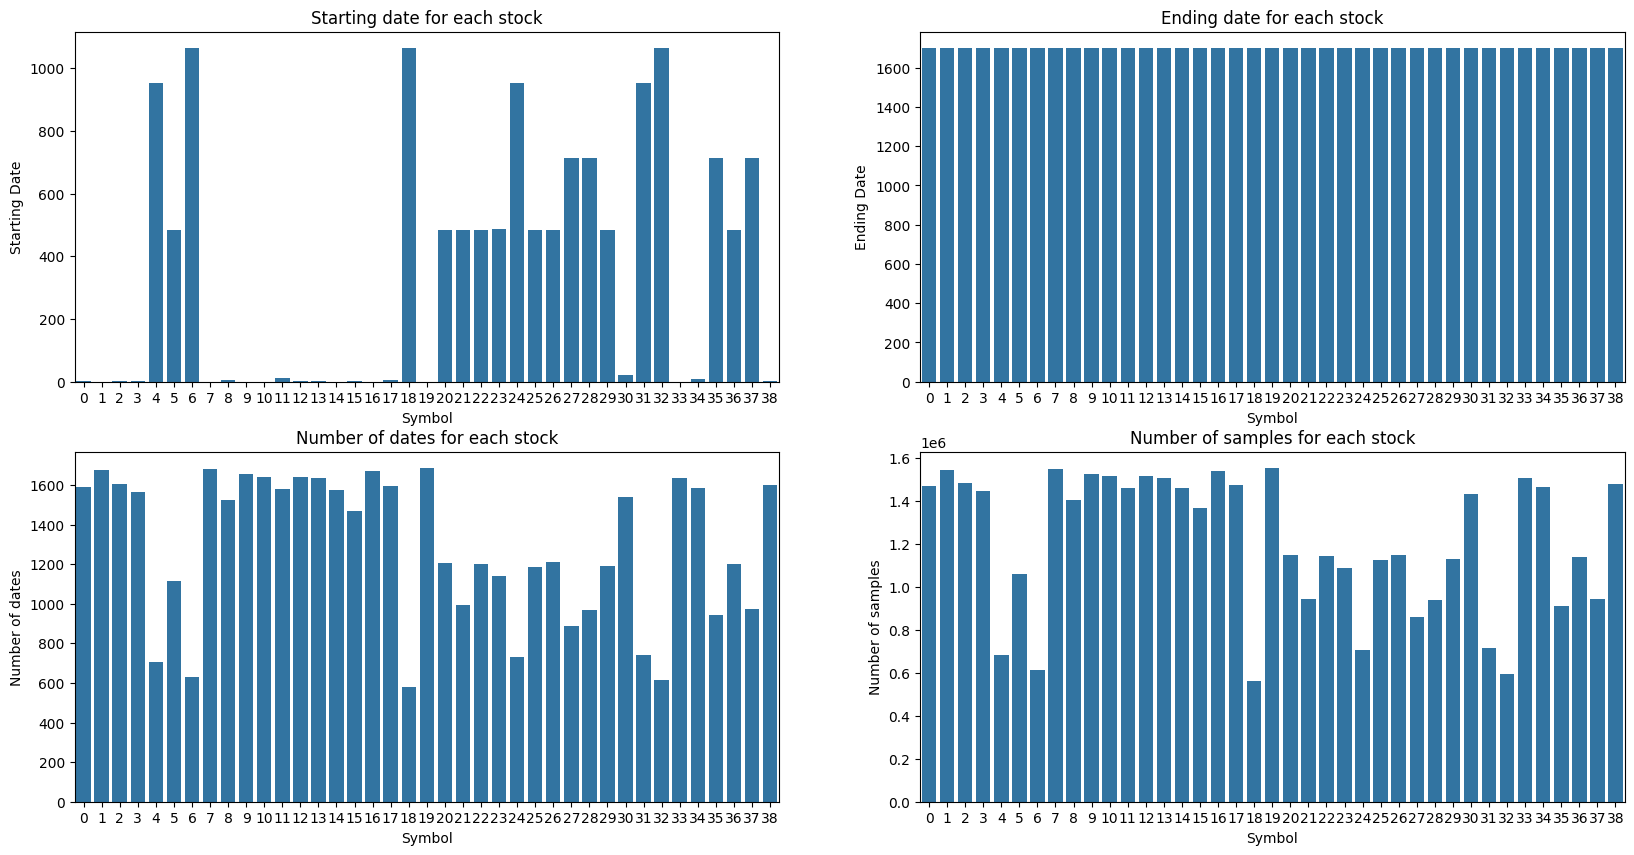

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()

sns.barplot(ax=axes[0], x=symbol_stats['symbol_id'].to_numpy(), y=symbol_stats['min_date_id'].to_numpy())
axes[0].set_xlabel('Symbol')
axes[0].set_ylabel('Starting Date')
axes[0].set_title('Starting date for each stock')

sns.barplot(ax=axes[1], x=symbol_stats['symbol_id'].to_numpy(), y=symbol_stats['max_date_id'].to_numpy())
axes[1].set_xlabel('Symbol')
axes[1].set_ylabel('Ending Date')
axes[1].set_title('Ending date for each stock')

sns.barplot(ax=axes[2], x=symbol_stats['symbol_id'].to_numpy(), y=symbol_stats['num_dates'].to_numpy())
axes[2].set_xlabel('Symbol')
axes[2].set_ylabel('Number of dates')
axes[2].set_title('Number of dates for each stock')

sns.barplot(ax=axes[3], x=symbol_stats['symbol_id'].to_numpy(), y=symbol_stats['num_samples'].to_numpy())
axes[3].set_xlabel('Symbol')
axes[3].set_ylabel('Number of samples')
axes[3].set_title('Number of samples for each stock')

# Basic Correlations

In [10]:
correlations = train_ds.drop(['date_id', 'time_id', 'symbol_id', 'weight']).drop_nulls().corr()
correlations.head()

/Users/lorecampa/Desktop/Projects/jane_street_forecasting/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/lorecampa/Desktop/Projects/jane_street_forecasting/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/lorecampa/Desktop/Projects/jane_street_forecasting/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/lorecampa/Desktop/Projects/jane_street_forecasting/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/lorecampa/Desktop/Projects/jane_street_forecasting/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value e

shape: (5, 88)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ feature_0 ┆ feature_0 ┆ feature_0 ┆ feature_0 ┆ … ┆ responder ┆ responder ┆ responder ┆ responde │
│ 0         ┆ 1         ┆ 2         ┆ 3         ┆   ┆ _5        ┆ _6        ┆ _7        ┆ r_8      │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ NaN       ┆ NaN       ┆ NaN       ┆ NaN       ┆ … ┆ NaN       ┆ NaN       ┆ NaN       ┆ NaN      │
│ NaN       ┆ NaN       ┆ NaN       ┆ NaN       ┆ … ┆ NaN       ┆ NaN       ┆ NaN       ┆ NaN      │
│ NaN       ┆ NaN       ┆ NaN       ┆ NaN       ┆ … ┆ NaN       ┆ NaN       ┆ NaN       ┆ NaN      │
│ NaN       ┆ NaN       ┆ NaN       ┆ NaN       ┆ … ┆ NaN       ┆ NaN       ┆ NaN       ┆ NaN      │
│ NaN       ┆ NaN       ┆ NaN       ┆ NaN       ┆ … ┆ NaN       ┆ NaN       ┆ NaN       ┆ NaN      │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

/Users/lorecampa/Desktop/Projects/jane_street_forecasting/.venv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/lorecampa/Desktop/Projects/jane_street_forecasting/.venv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


<Axes: >

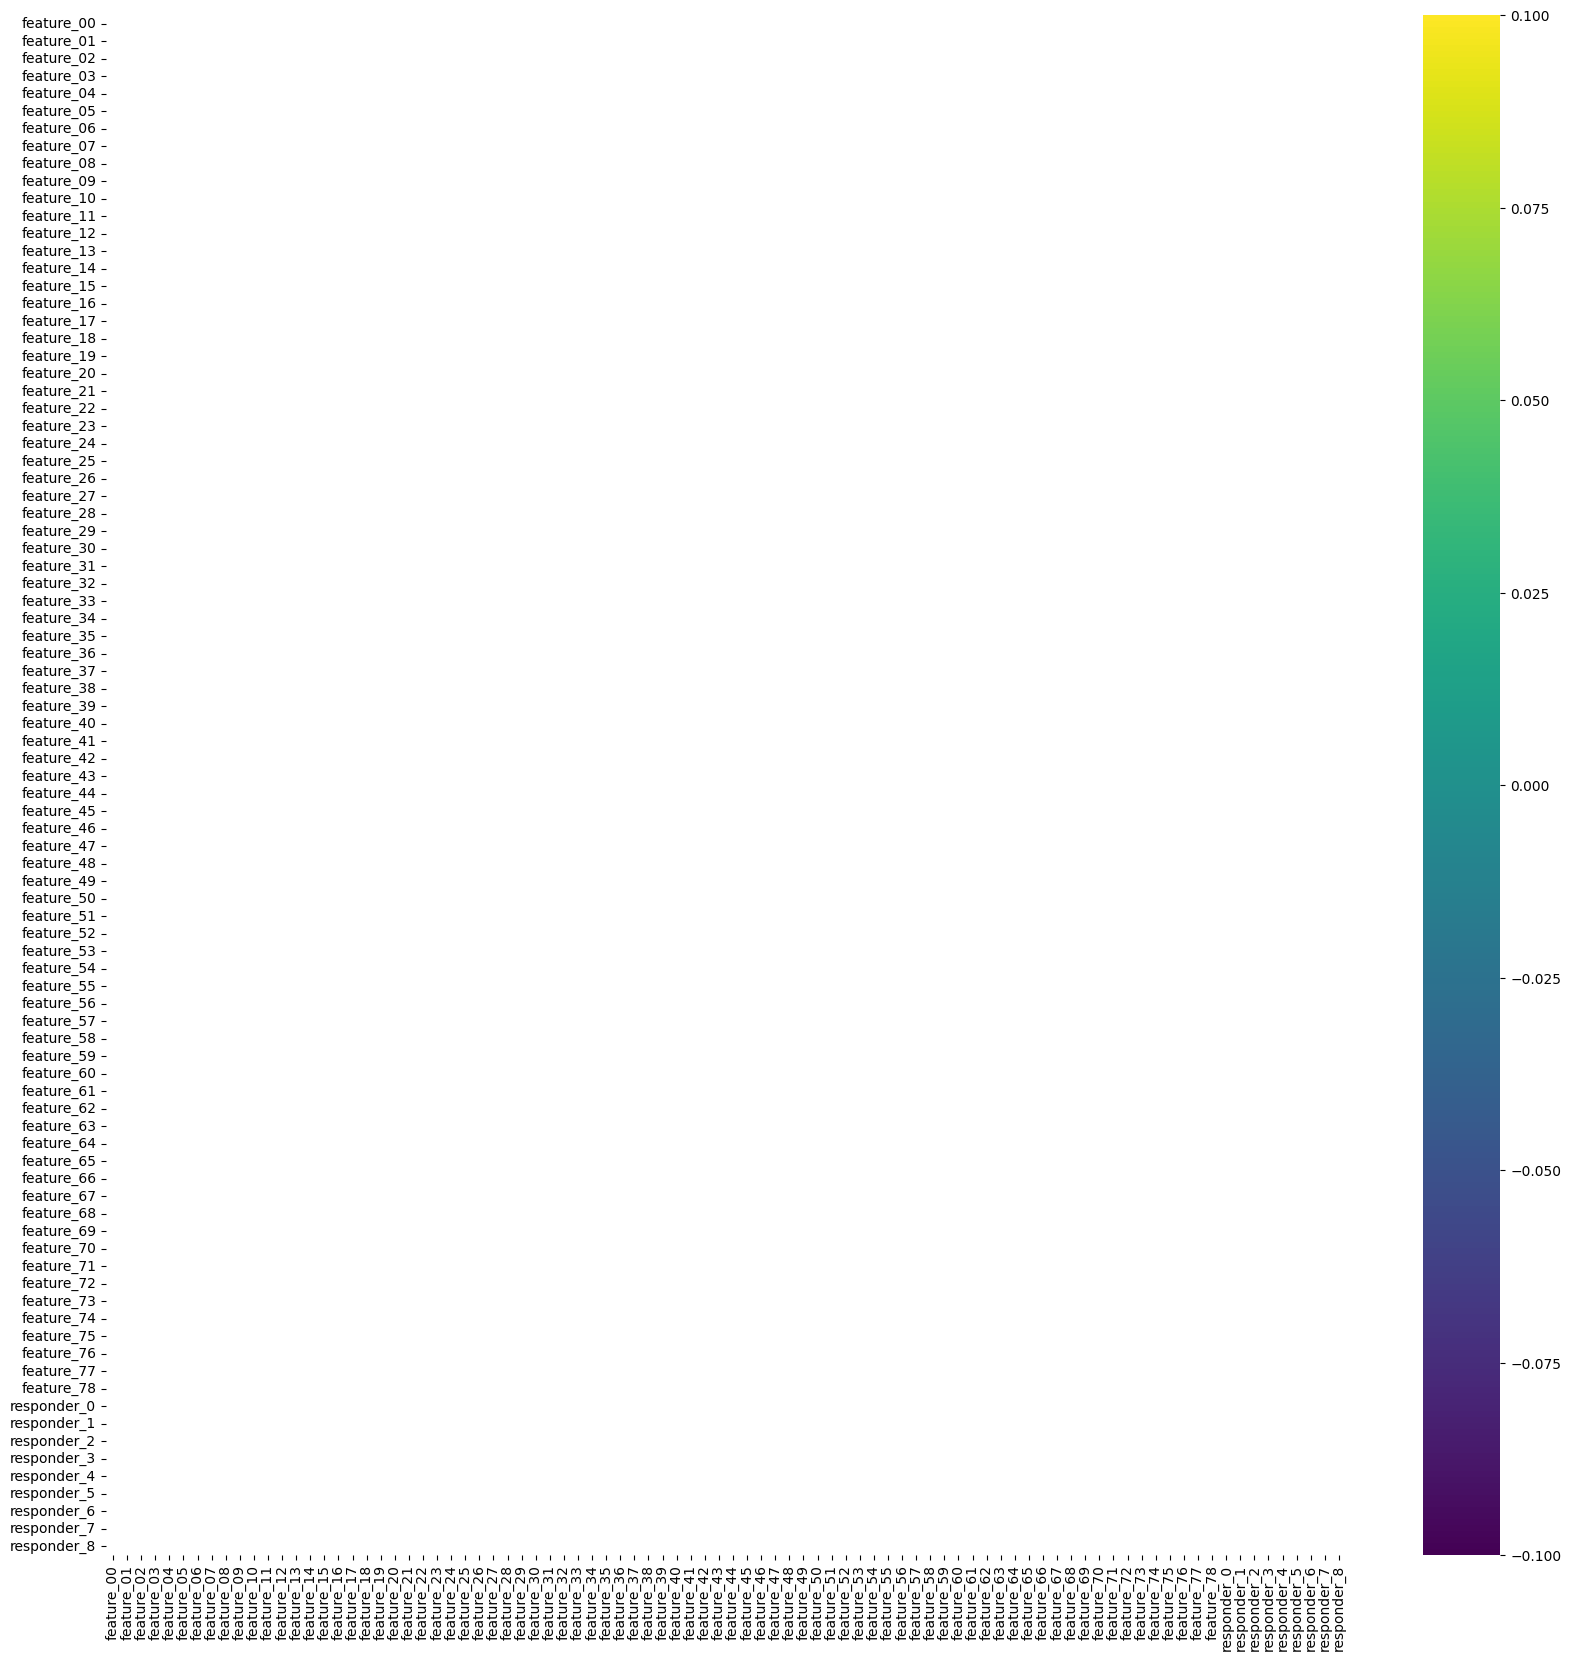

In [11]:
correlations = correlations.to_pandas()
correlations.index = correlations.columns.values

plt.figure(figsize=(20, 20))
sns.heatmap(correlations, cmap='viridis')

/Users/lorecampa/Desktop/Projects/jane_street_forecasting/.venv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/lorecampa/Desktop/Projects/jane_street_forecasting/.venv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


<Axes: >

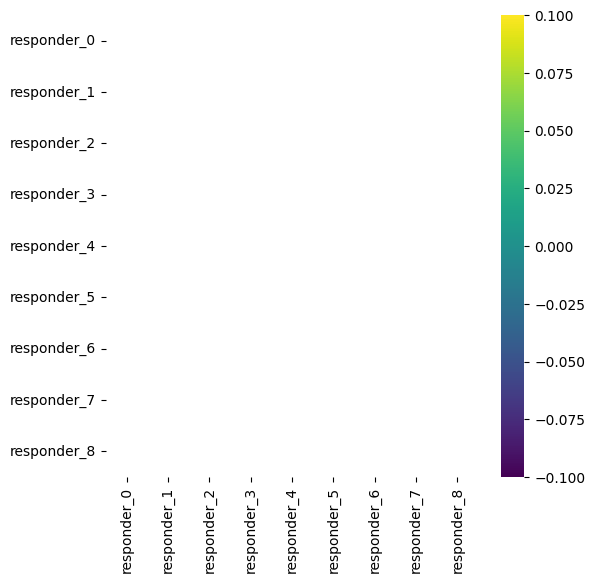

In [12]:
plt.figure(figsize=(6, 6))
sns.heatmap(correlations.iloc[-9:, -9:], cmap='viridis', annot=True)

Responder 6 and 3 are higly correlated

In [13]:
responders_tags = pl.read_csv(DATA_DIR / 'responders.csv')
responders_tags

shape: (9, 6)
┌─────────────┬───────┬───────┬───────┬───────┬───────┐
│ responder   ┆ tag_0 ┆ tag_1 ┆ tag_2 ┆ tag_3 ┆ tag_4 │
│ ---         ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---   │
│ str         ┆ bool  ┆ bool  ┆ bool  ┆ bool  ┆ bool  │
╞═════════════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ responder_0 ┆ true  ┆ false ┆ true  ┆ false ┆ false │
│ responder_1 ┆ true  ┆ false ┆ false ┆ true  ┆ false │
│ responder_2 ┆ true  ┆ true  ┆ false ┆ false ┆ false │
│ responder_3 ┆ false ┆ false ┆ true  ┆ false ┆ true  │
│ responder_4 ┆ false ┆ false ┆ false ┆ true  ┆ true  │
│ responder_5 ┆ false ┆ true  ┆ false ┆ false ┆ true  │
│ responder_6 ┆ false ┆ false ┆ true  ┆ false ┆ false │
│ responder_7 ┆ false ┆ false ┆ false ┆ true  ┆ false │
│ responder_8 ┆ false ┆ true  ┆ false ┆ false ┆ false │
└─────────────┴───────┴───────┴───────┴───────┴───────┘

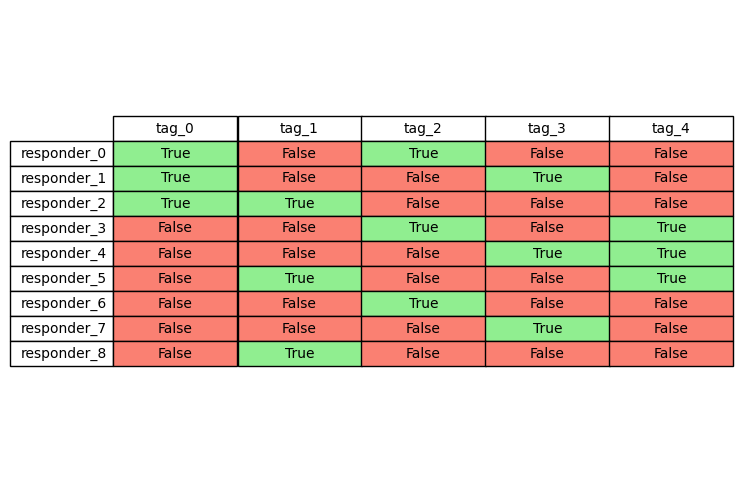

In [14]:
data = responders_tags.to_numpy()[:, 1:]

row_names = responders_tags['responder'].to_list()
col_names = responders_tags.columns[1:]

colors = np.where(data, "lightgreen", "salmon")

fig, ax = plt.subplots(figsize=(8, 6))
ax.axis("tight")
ax.axis("off")
cell_text = np.where(data, "True", "False")
table = ax.table(
    cellText=cell_text,
    cellColours=colors,
    rowLabels=row_names,
    colLabels=col_names,
    loc="center",
    cellLoc="center"
)
table.scale(1, 1.5)
plt.show()


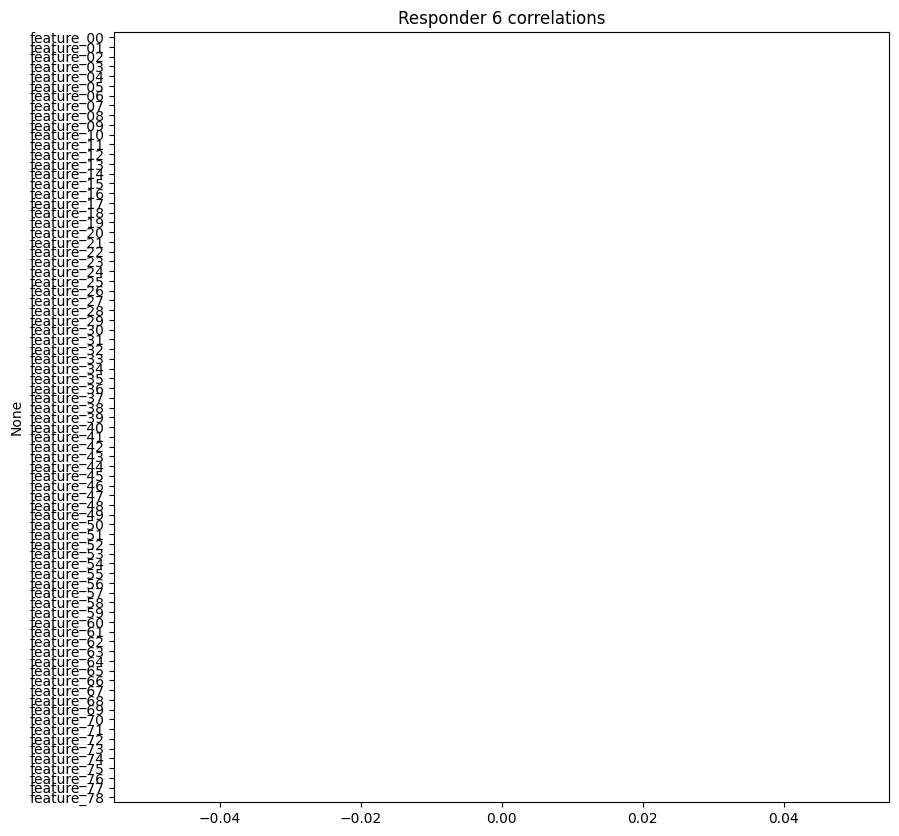

In [15]:
responder_6_correlations = correlations['responder_6'][:-9].sort_values(ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(y=responder_6_correlations.index, x=responder_6_correlations.values)
plt.title('Responder 6 correlations');

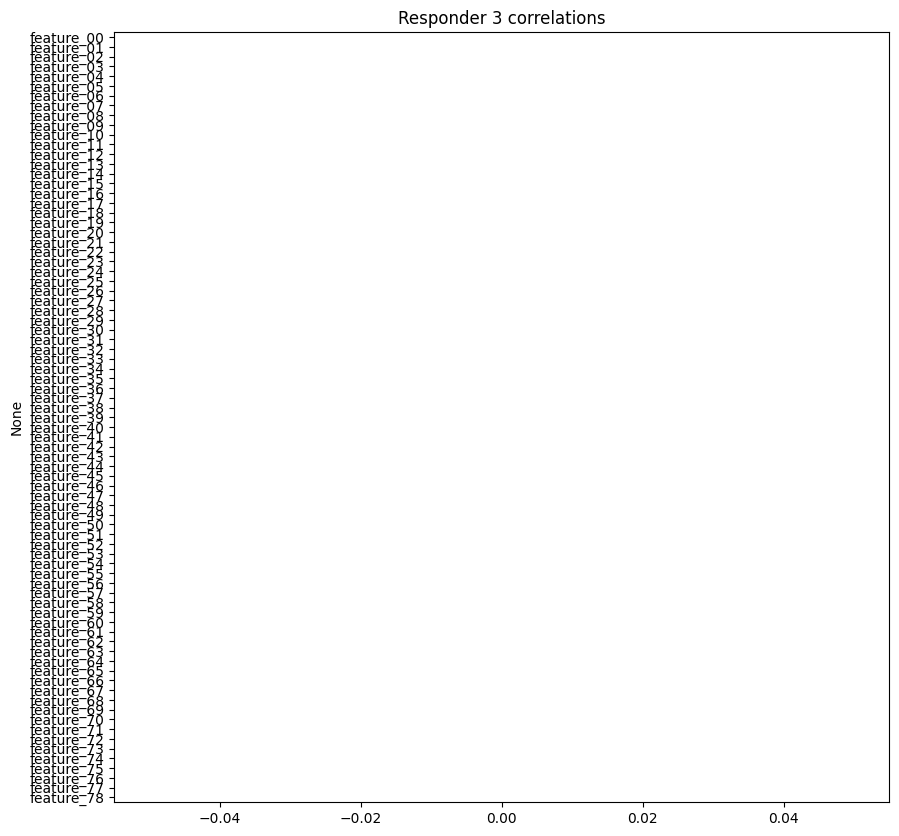

In [16]:
responder_3_correlations = correlations['responder_3'][:-9].sort_values(ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(y=responder_3_correlations.index, x=responder_3_correlations.values)
plt.title('Responder 3 correlations');

# Responders

In [17]:
RESPONDERS = [f'responder_{i}' for i in range(9)]

In [18]:
stock_1_responders = responders.filter(pl.col('symbol_id') == 1)
stock_1_responders.head(3)

shape: (3, 12)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0          ┆   ┆ 5          ┆ 6          ┆ _7        ┆ _8        │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆ f32        ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 340     ┆ 0       ┆ 1         ┆ -0.199408  ┆ … ┆ -0.58574   ┆ -0.891481  ┆ 0.184394  ┆ -0.402399 │
│ 340     ┆ 1       ┆ 1         ┆ -0.293198  ┆ … ┆ -0.714377  ┆ -1.070021  ┆ 0.204694  ┆ -0.449456 │
│ 340     ┆ 2       ┆ 1         ┆ -0.58928   ┆ … ┆ -0.798236  ┆ -0.776701  ┆ 0.209985  ┆ -0.372865 │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

<Axes: ylabel='Count'>

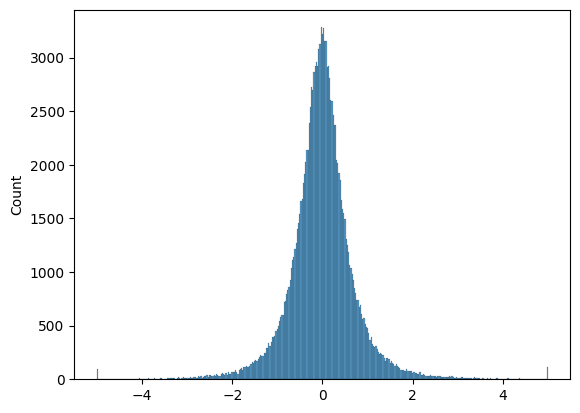

In [19]:
sns.histplot(stock_1_responders['responder_6'].to_numpy())

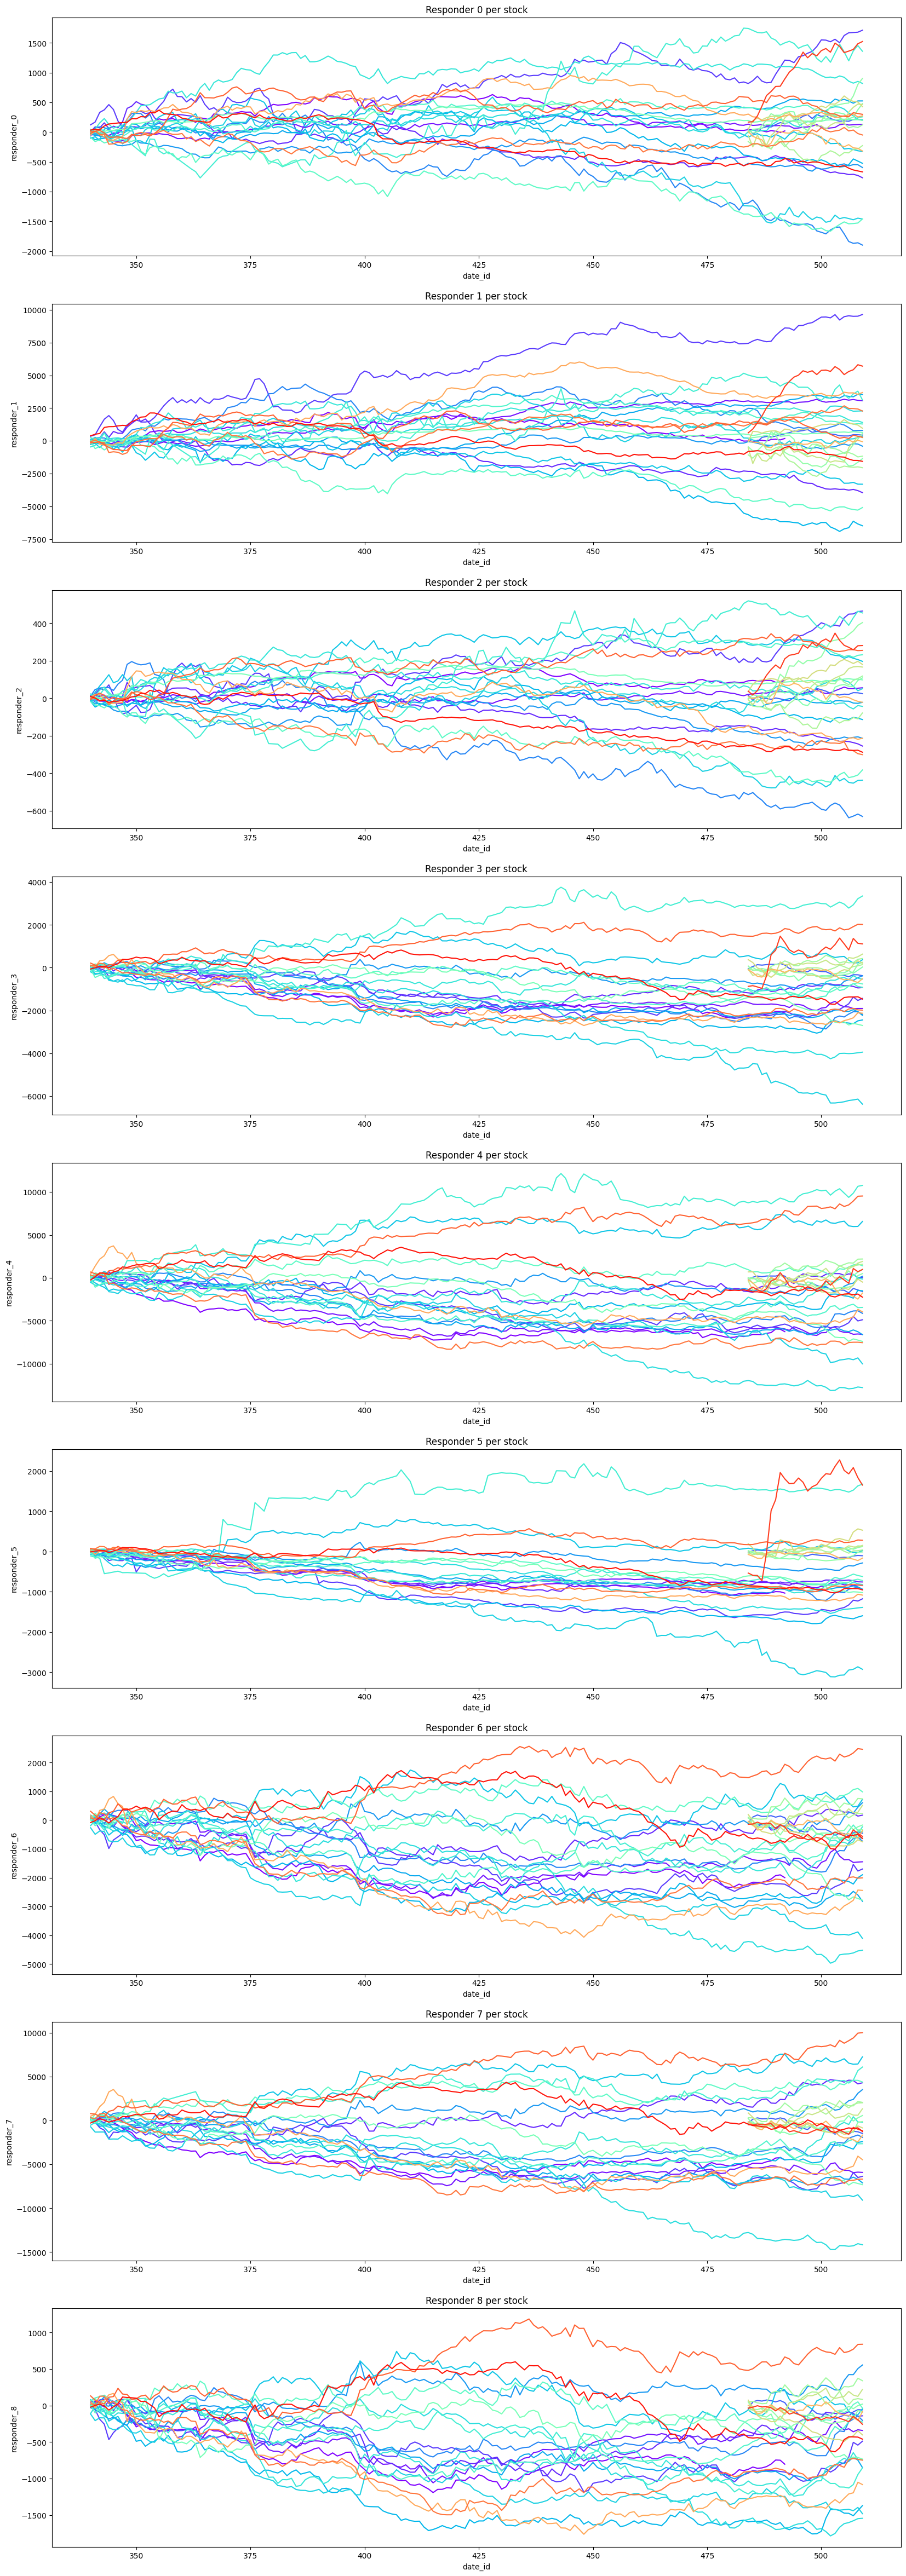

In [20]:
from matplotlib import cm

daily_responders = responders.group_by(['date_id', 'symbol_id']).agg(pl.col(RESPONDERS).sum())

colors = [cm.rainbow(i / 39)[:3] for i in range(39)]
fig, axes = plt.subplots(9, 1, figsize=(20, 60))

for i in range(9):
    for j in range(39):
        stock_data = daily_responders.filter(pl.col('symbol_id') == j).sort('date_id')
        axes[i].plot(stock_data['date_id'].to_numpy(), stock_data[f'responder_{i}'].to_numpy().cumsum(), color=colors[j])
    axes[i].set_xlabel('date_id')
    axes[i].set_ylabel(f'responder_{i}')
    axes[i].set_title(f'Responder {i} per stock')
    
plt.show()

In [21]:
time_responders = responders.group_by(['date_id', 'time_id']).agg(pl.col(RESPONDERS).sum())
time_responders.head()

shape: (5, 11)
┌─────────┬─────────┬────────────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ responder_ ┆ responder_ ┆ … ┆ responder_ ┆ responder ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ 0          ┆ 1          ┆   ┆ 5          ┆ _6        ┆ _7        ┆ _8        │
│ i16     ┆ i16     ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---       ┆ ---       ┆ ---       │
│         ┆         ┆ f32        ┆ f32        ┆   ┆ f32        ┆ f32       ┆ f32       ┆ f32       │
╞═════════╪═════════╪════════════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 419     ┆ 718     ┆ -0.658726  ┆ -0.856747  ┆ … ┆ 0.279629   ┆ 4.629258  ┆ -0.455841 ┆ -0.588627 │
│ 498     ┆ 664     ┆ 0.622823   ┆ -2.687718  ┆ … ┆ -5.124631  ┆ -8.612551 ┆ -4.828151 ┆ -4.479251 │
│ 361     ┆ 351     ┆ -1.030418  ┆ 1.98565    ┆ … ┆ -1.654341  ┆ 4.050024  ┆ 6.009208  ┆ -2.786124 │
│ 423     ┆ 368     ┆ 6.647501   ┆ 3.039986   ┆ … ┆ 2.37104    ┆ -0.906877 ┆ -8.84763  ┆ 0.292657  │
│ 482     ┆ 793     ┆ 1.017796   ┆ -5.342219  ┆ … ┆ 1.668517   ┆ -2.414448 ┆ -1.370682 ┆ 2.566993  │
└─────────┴─────────┴────────────┴────────────┴───┴────────────┴───────────┴───────────┴───────────┘

Responder 6 is not zero-sum at the same time (not normalized w.r.t. the market)

<Axes: ylabel='Count'>

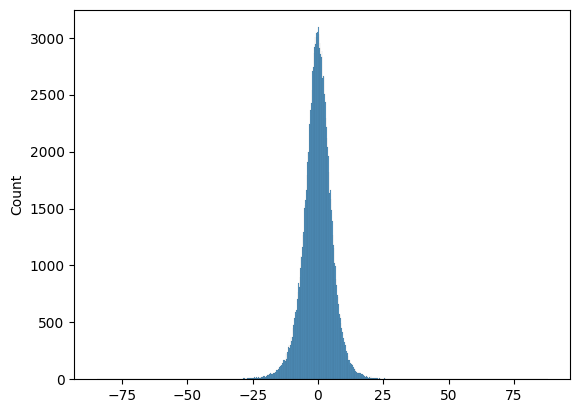

In [22]:
sns.histplot(time_responders['responder_6'].to_numpy())

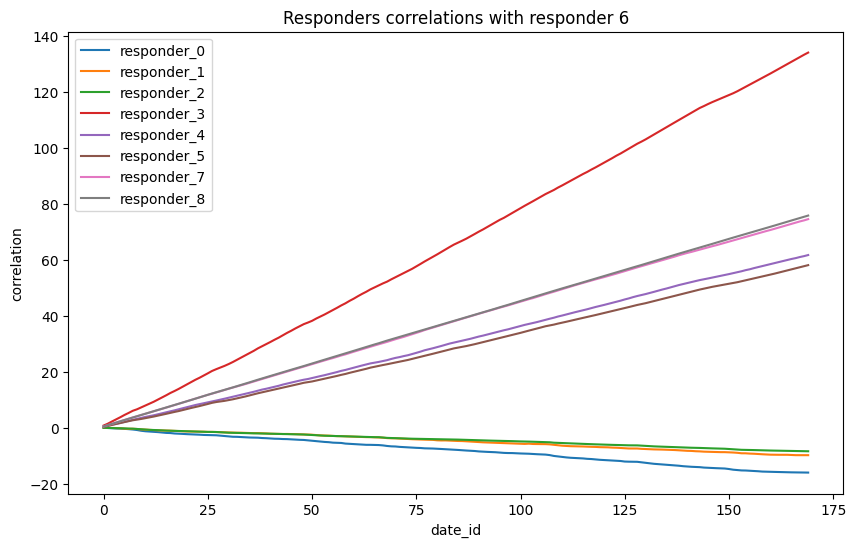

In [23]:
daily_cumulative_correlations = responders.group_by('date_id').agg(
    pl.corr(f'responder_{i}', 'responder_6') for i in range(9) if i != 6
).sort('date_id').with_columns(pl.col(f'responder_{i}').cum_sum() for i in range(9) if i != 6)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    if i != 6:
        ax.plot(daily_cumulative_correlations[f'responder_{i}'], label=f'responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Responders correlations with responder 6')
ax.legend()
plt.show()

# Lagged Responders

In [24]:
responders = train_ds.select(['date_id', 'time_id', 'symbol_id'] + [f'responder_{i}' for i in range(9)])

agg_responders = responders.group_by(['date_id', 'symbol_id']).agg(
    [pl.col(f'responder_{i}').sum().alias(f'total_responder_{i}') for i in range(9)] + \
    [pl.col(f'responder_{i}').mean().alias(f'mean_responder_{i}') for i in range(9)]
).with_columns(pl.col('date_id').add(1))
one_day_lagged_responders = responders.with_columns(pl.col('date_id').add(1))

responders = responders.join(agg_responders, on=['date_id', 'symbol_id'], how='left') \
    .join(one_day_lagged_responders, on=['date_id', 'time_id', 'symbol_id']) \
    .rename({f'responder_{i}_right': f'responder_{i}_lag_daily' for i in range(9)}) \
    .sort(['date_id', 'time_id', 'symbol_id'])
responders.tail(5)

shape: (5, 39)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0          ┆   ┆ 5_lag_dail ┆ 6_lag_dail ┆ _7_lag_da ┆ _8_lag_da │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ y          ┆ y          ┆ ily       ┆ ily       │
│         ┆         ┆           ┆ f32        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆            ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 509     ┆ 848     ┆ 30        ┆ 1.448597   ┆ … ┆ -2.05835   ┆ -0.040522  ┆ -0.008248 ┆ -0.199511 │
│ 509     ┆ 848     ┆ 33        ┆ -0.031795  ┆ … ┆ -0.172271  ┆ 0.356951   ┆ 0.175829  ┆ 0.624159  │
│ 509     ┆ 848     ┆ 34        ┆ 1.331511   ┆ … ┆ -0.278398  ┆ -0.049286  ┆ -0.000382 ┆ -0.110512 │
│ 509     ┆ 848     ┆ 36        ┆ 1.904021   ┆ … ┆ 3.013043   ┆ -0.040267  ┆ 0.010436  ┆ -0.073188 │
│ 509     ┆ 848     ┆ 38        ┆ -0.5545    ┆ … ┆ -0.972681  ┆ -0.493724  ┆ -0.090662 ┆ -0.803939 │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

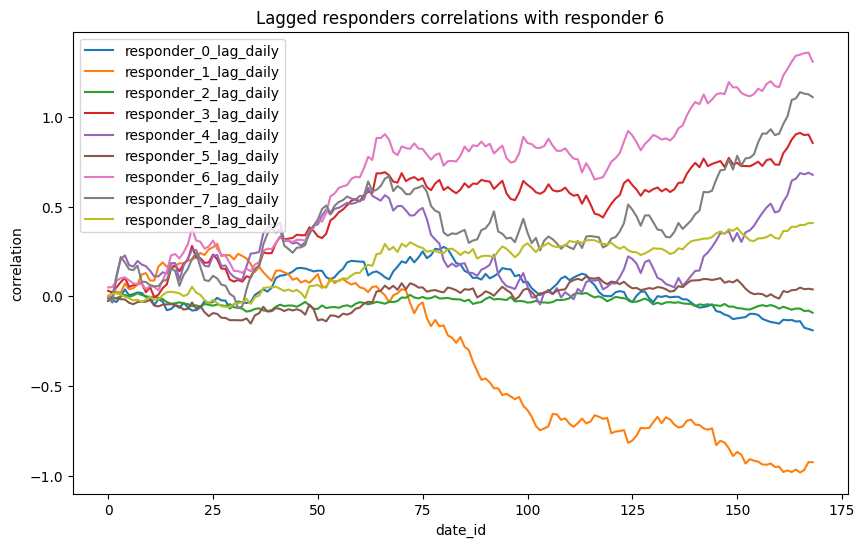

In [25]:
daily_cumulative_correlations = responders.group_by('date_id').agg(
    pl.corr(f'responder_{i}_lag_daily', 'responder_6') for i in range(9)
).sort('date_id').with_columns(pl.col(f'responder_{i}_lag_daily').cum_sum() for i in range(9))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'responder_{i}_lag_daily'], label=f'responder_{i}_lag_daily')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Lagged responders correlations with responder 6')
ax.legend()
plt.show()

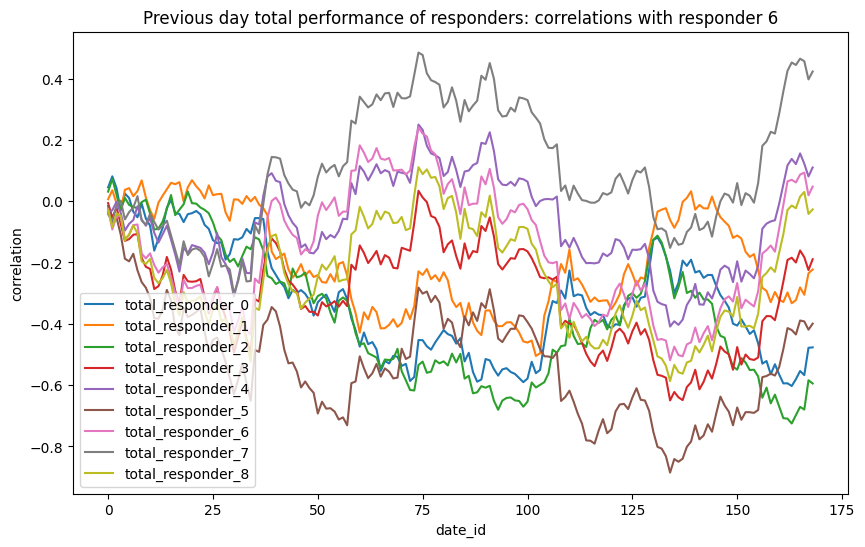

In [26]:
daily_cumulative_correlations = responders.group_by('date_id').agg(
    pl.corr(f'total_responder_{i}', 'responder_6') for i in range(9)
).sort('date_id').with_columns(pl.col(f'total_responder_{i}').cum_sum() for i in range(9))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'total_responder_{i}'], label=f'total_responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Previous day total performance of responders: correlations with responder 6')
ax.legend()
plt.show()

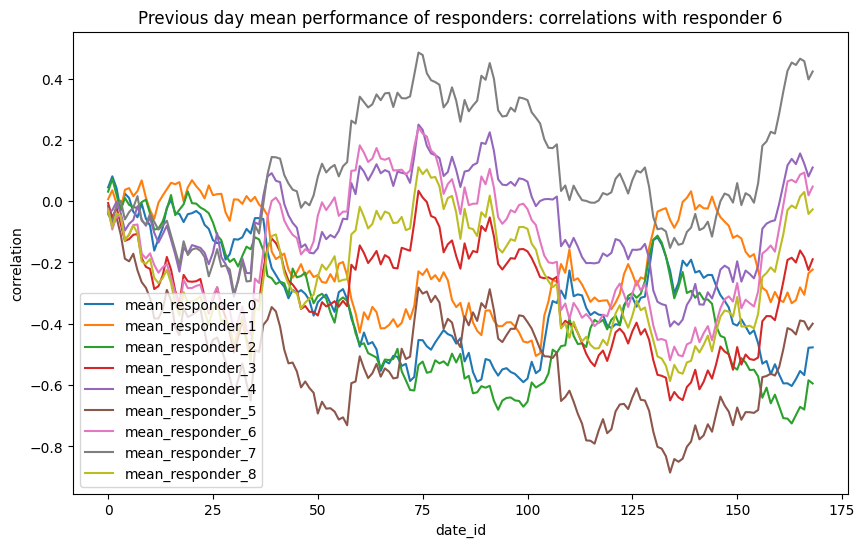

In [27]:
daily_cumulative_correlations = responders.group_by('date_id').agg(
    pl.corr(f'mean_responder_{i}', 'responder_6') for i in range(9)
).sort('date_id').with_columns(pl.col(f'mean_responder_{i}').cum_sum() for i in range(9))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'mean_responder_{i}'], label=f'mean_responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Previous day mean performance of responders: correlations with responder 6')
ax.legend()
plt.show()

In [28]:
weekly_performances = responders.group_by(['date_id', 'symbol_id']).agg(
    [pl.col(f'responder_{i}_lag_daily').sum().alias(f'daily_performance_responder_{i}') for i in range(9)] + \
    [pl.col('time_id').count().alias('num_times')]
).with_columns(
    [pl.col(f'daily_performance_responder_{i}').rolling_sum(7, min_periods=1).alias(f'weekly_performance_responder_{i}') for i in range(9)] + \
    [pl.col('num_times').rolling_sum(7, min_periods=1).alias('num_times_week')]
).with_columns(
    pl.col(f'weekly_performance_responder_{i}').truediv('num_times_week').alias(f'weekly_mean_performance_responder_{i}') for i in range(9)
)
weekly_performances.tail()

shape: (5, 31)
┌─────────┬───────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ date_id ┆ symbol_id ┆ daily_perf ┆ daily_per ┆ … ┆ weekly_me ┆ weekly_me ┆ weekly_me ┆ weekly_me │
│ ---     ┆ ---       ┆ ormance_re ┆ formance_ ┆   ┆ an_perfor ┆ an_perfor ┆ an_perfor ┆ an_perfor │
│ i16     ┆ i8        ┆ sponder_0  ┆ responder ┆   ┆ mance_res ┆ mance_res ┆ mance_res ┆ mance_res │
│         ┆           ┆ ---        ┆ _1        ┆   ┆ pon…      ┆ pon…      ┆ pon…      ┆ pon…      │
│         ┆           ┆ f32        ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│         ┆           ┆            ┆ f32       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═════════╪═══════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 493     ┆ 16        ┆ 39.360394  ┆ 186.38487 ┆ … ┆ -0.021133 ┆ -0.055829 ┆ -0.119059 ┆ -0.025499 │
│         ┆           ┆            ┆ 2         ┆   ┆           ┆           ┆           ┆           │
│ 505     ┆ 33        ┆ 12.873629  ┆ 106.43628 ┆ … ┆ -0.016244 ┆ -0.048528 ┆ -0.105982 ┆ -0.021476 │
│         ┆           ┆            ┆ 7         ┆   ┆           ┆           ┆           ┆           │
│ 430     ┆ 3         ┆ 16.977425  ┆ 186.94757 ┆ … ┆ -0.001133 ┆ -0.016725 ┆ -0.056236 ┆ -0.001118 │
│         ┆           ┆            ┆ 1         ┆   ┆           ┆           ┆           ┆           │
│ 416     ┆ 11        ┆ 42.209587  ┆ -66.15755 ┆ … ┆ -0.007543 ┆ -0.038044 ┆ -0.037535 ┆ -0.01067  │
│         ┆           ┆            ┆ 5         ┆   ┆           ┆           ┆           ┆           │
│ 455     ┆ 8         ┆ -5.120255  ┆ -7.288672 ┆ … ┆ -0.014941 ┆ -0.060754 ┆ -0.085269 ┆ -0.022545 │
└─────────┴───────────┴────────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

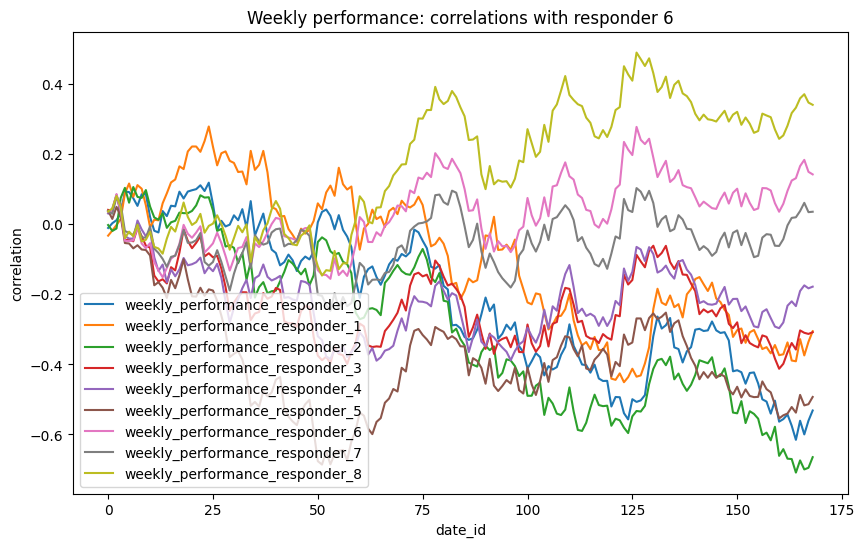

In [29]:
daily_cumulative_correlations = responders \
    .join(weekly_performances, on=['symbol_id', 'date_id']).group_by('date_id').agg(
        [pl.corr(f'weekly_performance_responder_{i}', 'responder_6') for i in range(9)] + \
        [pl.corr(f'weekly_mean_performance_responder_{i}', 'responder_6') for i in range(9)]
    ).sort('date_id')\
    .with_columns(
        *[pl.col(f'weekly_performance_responder_{i}').cum_sum() for i in range(9)],
        *[pl.col(f'weekly_mean_performance_responder_{i}').cum_sum() for i in range(9)]
    )

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'weekly_performance_responder_{i}'], label=f'weekly_performance_responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Weekly performance: correlations with responder 6')
ax.legend()
plt.show()

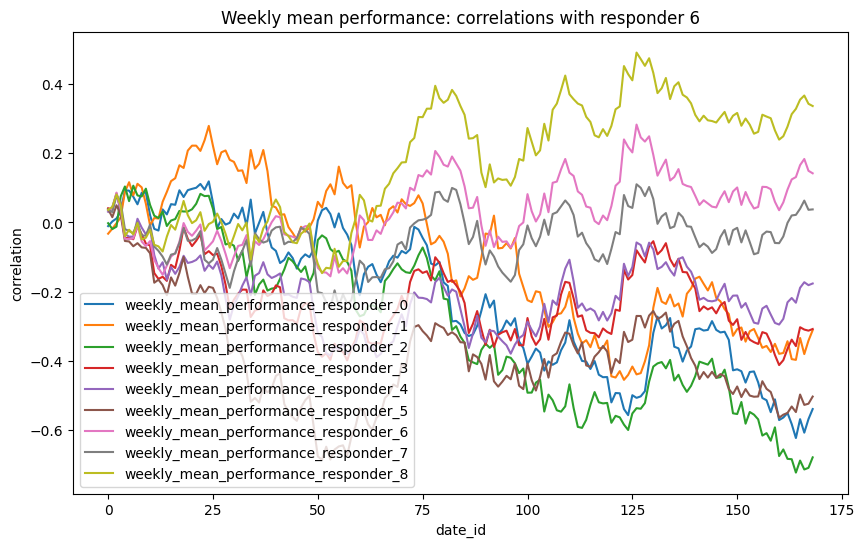

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'weekly_mean_performance_responder_{i}'], label=f'weekly_mean_performance_responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Weekly mean performance: correlations with responder 6')
ax.legend()
plt.show()

In [31]:
responders = responders.sort(['date_id', 'time_id', 'symbol_id'])
responders.head(3)

shape: (3, 39)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0          ┆   ┆ 5_lag_dail ┆ 6_lag_dail ┆ _7_lag_da ┆ _8_lag_da │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ y          ┆ y          ┆ ily       ┆ ily       │
│         ┆         ┆           ┆ f32        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆            ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 341     ┆ 0       ┆ 0         ┆ -0.61334   ┆ … ┆ 0.814566   ┆ -0.132949  ┆ 1.183992  ┆ 0.371725  │
│ 341     ┆ 0       ┆ 1         ┆ 0.443406   ┆ … ┆ -0.58574   ┆ -0.891481  ┆ 0.184394  ┆ -0.402399 │
│ 341     ┆ 0       ┆ 2         ┆ 0.360815   ┆ … ┆ 0.217188   ┆ 4.563775   ┆ 0.802501  ┆ 1.707263  │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

In [32]:
features = [f'responder_{i}_lag_daily' for i in range(9)] + [f'total_responder_{i}' for i in range(9)] + [f'mean_responder_{i}' for i in range(9)]
target = 'responder_6'
daily_corr = responders.group_by(['date_id']).agg(
    pl.corr(f, target).name.keep() for f in features
).with_columns(
    #Flip sign for negative mean correlation since we only care about magnitude
    pl.all().exclude('date_id').mul(pl.all().exclude('date_id').mean().sign()).name.keep()
).sort('date_id')
daily_corr

shape: (169, 28)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ date_id ┆ responder_ ┆ responder ┆ responder ┆ … ┆ mean_resp ┆ mean_resp ┆ mean_resp ┆ mean_resp │
│ ---     ┆ 0_lag_dail ┆ _1_lag_da ┆ _2_lag_da ┆   ┆ onder_5   ┆ onder_6   ┆ onder_7   ┆ onder_8   │
│ i16     ┆ y          ┆ ily       ┆ ily       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│         ┆ ---        ┆ ---       ┆ ---       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
│         ┆ f64        ┆ f64       ┆ f64       ┆   ┆           ┆           ┆           ┆           │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 341     ┆ 0.011082   ┆ -0.001163 ┆ 0.025178  ┆ … ┆ 0.015912  ┆ -0.025718 ┆ -0.042639 ┆ 0.028381  │
│ 342     ┆ 0.011738   ┆ -0.016253 ┆ -0.012005 ┆ … ┆ 0.063732  ┆ -0.0667   ┆ -0.023821 ┆ 0.057371  │
│ 343     ┆ 0.009364   ┆ -0.008112 ┆ -0.002814 ┆ … ┆ -0.026418 ┆ 0.044432  ┆ 0.051386  ┆ -0.045572 │
│ 344     ┆ -0.031942  ┆ 0.005735  ┆ -0.009199 ┆ … ┆ 0.055642  ┆ -0.001841 ┆ 0.016649  ┆ 0.007625  │
│ 345     ┆ -0.038456  ┆ -0.0506   ┆ -0.008917 ┆ … ┆ 0.078986  ┆ -0.074752 ┆ -0.061169 ┆ 0.080558  │
│ …       ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 505     ┆ 0.00838    ┆ -0.013587 ┆ -0.006571 ┆ … ┆ 0.0146    ┆ -0.008673 ┆ -0.007982 ┆ 0.008735  │
│ 506     ┆ -0.001312  ┆ 0.016789  ┆ 0.000218  ┆ … ┆ -0.045565 ┆ 0.025647  ┆ 0.020489  ┆ -0.037986 │
│ 507     ┆ 0.036029   ┆ -0.014947 ┆ 0.013437  ┆ … ┆ 0.002936  ┆ 0.006482  ┆ -0.008162 ┆ -0.015041 │
│ 508     ┆ 0.006828   ┆ -0.043483 ┆ -0.0019   ┆ … ┆ 0.026965  ┆ -0.074125 ┆ -0.059425 ┆ 0.071783  │
│ 509     ┆ 0.007895   ┆ 0.000679  ┆ 0.011779  ┆ … ┆ -0.019658 ┆ 0.028396  ┆ 0.025759  ┆ -0.014988 │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [33]:
def metrics(corr):
    corr_mean = corr.mean()
    corr_std = corr.std(ddof=0)
    corr_sharpe = corr_mean / corr_std
    max_drawdown = -(corr.cumsum().expanding(min_periods=1).max() - corr.cumsum()).max()

    eras = daily_corr['date_id'].unique().sort().to_list()
    halfway_era = len(eras)//2
    corr_mean_first_half = corr.loc[eras[:halfway_era]].mean()
    corr_mean_second_half = corr.loc[eras[halfway_era:]].mean()

    delta = abs(corr_mean_first_half - corr_mean_second_half)

    return {
      "mean": corr_mean,
      "std": corr_std,
      "sharpe": corr_sharpe,
      "max_drawdown": max_drawdown,
      "delta": delta
    }

per_era_corr = daily_corr.to_pandas().set_index('date_id')
# compute performance metrics for each feature
feature_metrics = [
    metrics(per_era_corr[feature_name])
    for feature_name in features
]

# convert to numeric DataFrame and sort
feature_metrics = (
    pd.DataFrame(feature_metrics, index=features)
    .apply(pd.to_numeric)
    .sort_values("mean", ascending=False)
)

feature_metrics

mean       std    sharpe  max_drawdown     delta
responder_6_lag_daily  0.007732  0.035094  0.220332     -0.252068  0.002398
responder_7_lag_daily  0.006563  0.045238  0.145084     -0.411707  0.004843
responder_1_lag_daily  0.005473  0.030311  0.180571     -0.291645  0.004725
responder_3_lag_daily  0.005053  0.032096  0.157448     -0.252474  0.003536
responder_4_lag_daily  0.004002  0.040330  0.099239     -0.649760  0.004048
mean_responder_2       0.003520  0.036412  0.096683     -0.568130  0.005462
total_responder_2      0.003520  0.036412  0.096683     -0.568130  0.005462
mean_responder_0       0.002823  0.038691  0.072968     -0.472010  0.005390
total_responder_0      0.002823  0.038691  0.072968     -0.472010  0.005390
mean_responder_7       0.002502  0.046400  0.053932     -0.637272  0.002778
total_responder_7      0.002502  0.046400  0.053932     -0.637272  0.002778
responder_8_lag_daily  0.002413  0.018876  0.127844     -0.113314  0.001118
total_responder_5      0.002365  0.046981  0.050346     -0.496183  0.006017
mean_responder_5       0.002365  0.046981  0.050346     -0.496183  0.006017
total_responder_1      0.001321  0.038806  0.034036     -0.537358  0.005556
mean_responder_1       0.001321  0.038806  0.034036     -0.537358  0.005556
responder_0_lag_daily  0.001125  0.021736  0.051738     -0.354455  0.006600
total_responder_3      0.001122  0.046518  0.024114     -0.529902  0.002021
mean_responder_3       0.001122  0.046518  0.024114     -0.529902  0.002021
mean_responder_4       0.000650  0.044334  0.014664     -0.658870  0.001112
total_responder_4      0.000650  0.044334  0.014664     -0.658870  0.001112
responder_2_lag_daily  0.000545  0.009702  0.056199     -0.103948  0.000685
total_responder_6      0.000280  0.048219  0.005810     -0.759210  0.000037
mean_responder_6       0.000280  0.048219  0.005810     -0.759210  0.000037
responder_5_lag_daily  0.000224  0.018865  0.011866     -0.140957  0.000341
total_responder_8      0.000159  0.049057  0.003246     -0.635024  0.000570
mean_responder_8       0.000159  0.049057  0.003246     -0.635024  0.000570

array([[<Axes: title={'center': 'mean'}>,
        <Axes: title={'center': 'std'}>,
        <Axes: title={'center': 'sharpe'}>],
       [<Axes: title={'center': 'max_drawdown'}>,
        <Axes: title={'center': 'delta'}>, <Axes: >]], dtype=object)

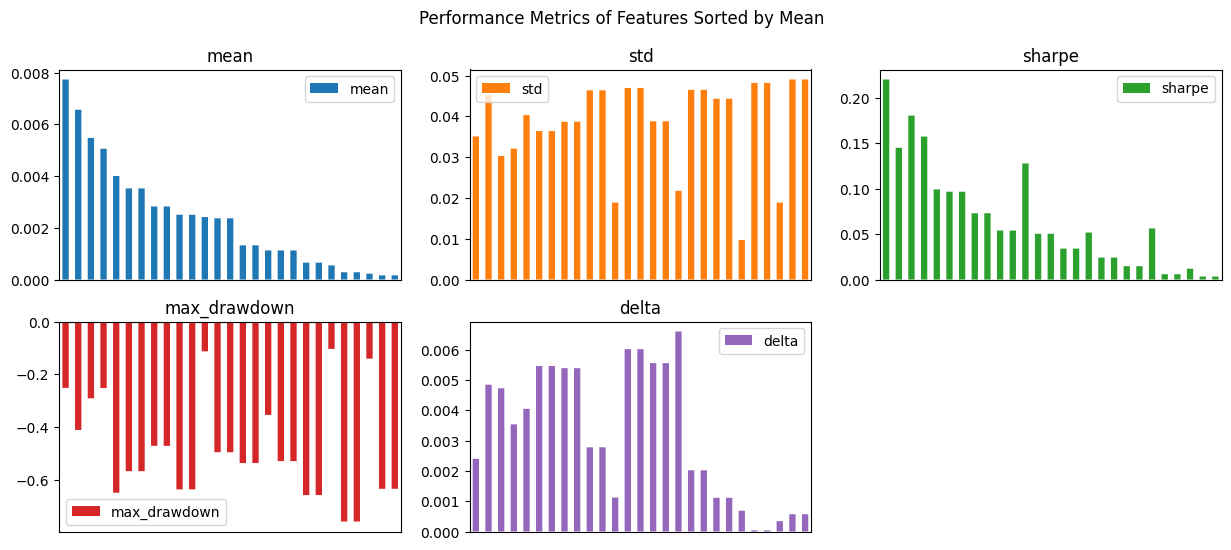

In [34]:
feature_metrics.sort_values("mean", ascending=False).plot.bar(
    title="Performance Metrics of Features Sorted by Mean",
    subplots=True,
    figsize=(15, 6),
    layout=(2, 3),
    sharex=False,
    xticks=[],
    snap=False
)

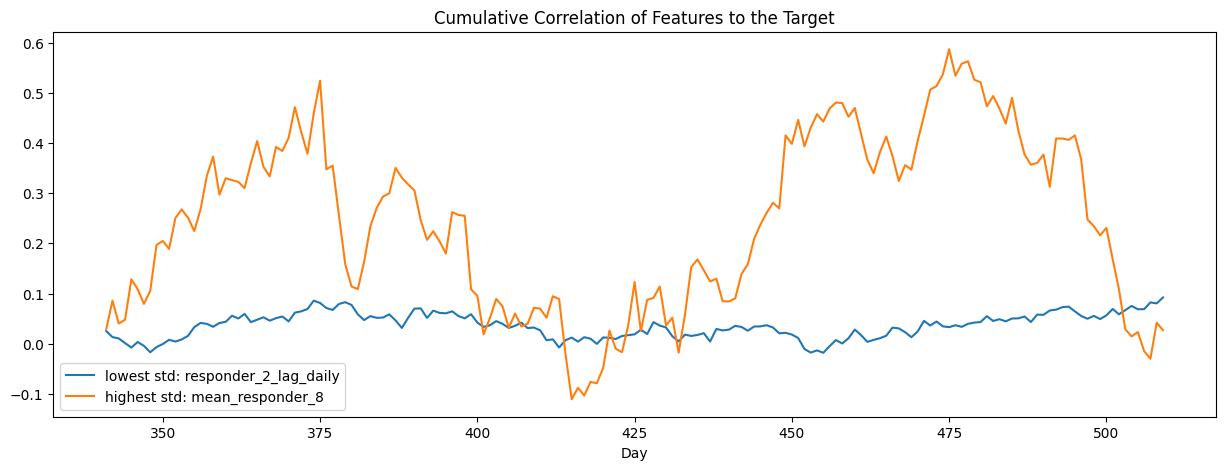

In [35]:
metric="std"
min_f, max_f = feature_metrics[metric].idxmin(), feature_metrics[metric].idxmax()
per_era_corr[[min_f, max_f]].cumsum().plot(
    figsize=(15, 5), title="Cumulative Correlation of Features to the Target", xlabel="Day"
)
plt.legend([f"lowest {metric}: {min_f}", f"highest {metric}: {max_f}"])

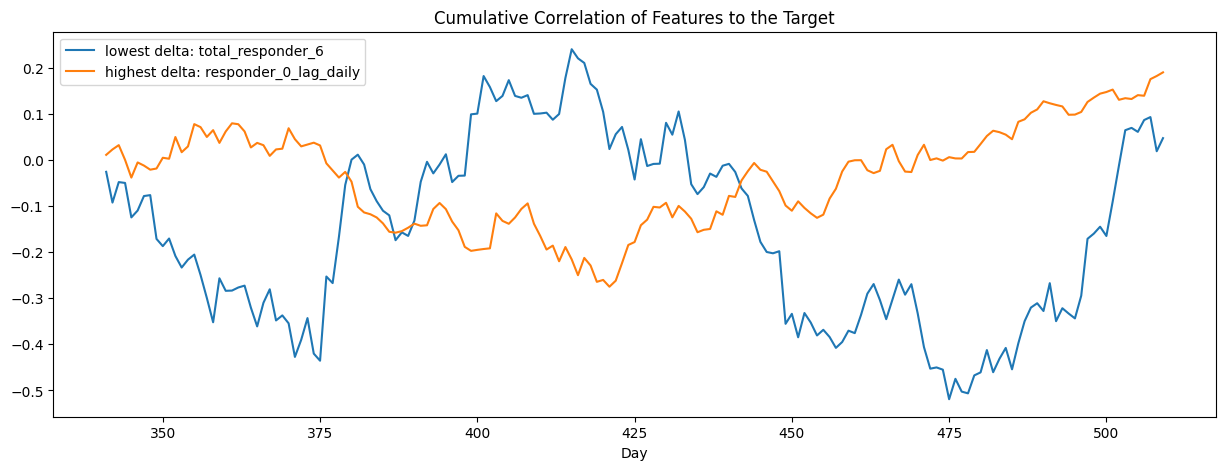

In [36]:
metric="delta"
min_f, max_f = feature_metrics[metric].idxmin(), feature_metrics[metric].idxmax()
per_era_corr[[min_f, max_f]].cumsum().plot(
    figsize=(15, 5), title="Cumulative Correlation of Features to the Target", xlabel="Day"
)
plt.legend([f"lowest {metric}: {min_f}", f"highest {metric}: {max_f}"])

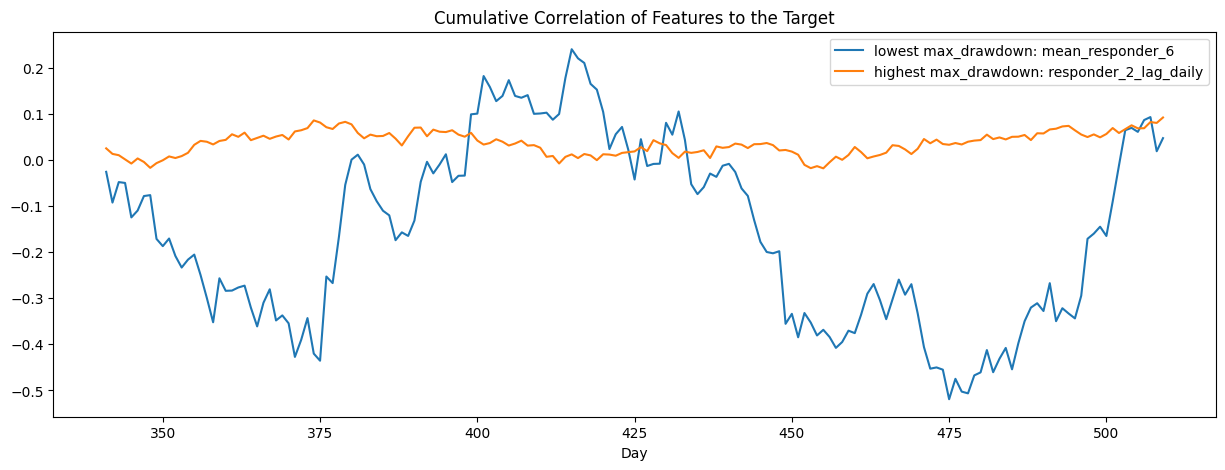

In [37]:
metric="max_drawdown"
min_f, max_f = feature_metrics[metric].idxmin(), feature_metrics[metric].idxmax()
per_era_corr[[min_f, max_f]].cumsum().plot(
    figsize=(15, 5), title="Cumulative Correlation of Features to the Target", xlabel="Day"
)
plt.legend([f"lowest {metric}: {min_f}", f"highest {metric}: {max_f}"])